# Описание проекта:

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».\
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
- Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.
- В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.
- Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

| Тариф                            | Смарт                              | Ультра                              |
|----------------------------------|------------------------------------|-------------------------------------|
| Ежемесячная плата                | 550 рублей                         | 1950 рублей                         |
| Включено                         | 500 минут разговора                | 3000 минут разговора                |
|                                  | 50 сообщений                       | 1000 сообщений                      |
|                                  | 15 Гб интернет-трафика             | 30 Гб интернет-трафика              |
| Стоимость услуг сверх тарифного пакета:                                                                     |
| минута разговора:                | 3 рубля                            | 1 рубль                             | 
| сообщение:                       | 3 рубля                            | 1 рубль                             |
| 1 Гб интернет-трафика:           | 200 рублей                         | 150 рублей                          |

Примечание:
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. 
- Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер звонка
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Общая информация

In [ ]:
import pandas as pd

from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math


#df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [ ]:
# можно было бы сделать через цикл, но получается слишком длинный список данных на выходе 

#for df in [df_calls, df_internet, df_messages, df_tariffs, df_users]:
#    print(df.info())
#    print(df.isna().sum())
#    print(df.duplicated().sum())
#    print(df.describe())
#    print(df.sample(3))

In [ ]:
# поэтому будем знакомиться с данными по очереди 
print(df_calls.info())
print(df_calls.isna().sum())
print('______________________количество дубликатов', df_calls.duplicated().sum())
print(df_calls.describe().round(2))
print(df_calls.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
id           0
call_date    0
duration     0
user_id      0
dtype: int64
______________________количество дубликатов 0
        duration    user_id
count  202607.00  202607.00
mean        6.76    1253.94
std         5.84     144.72
min         0.00    1000.00
25%         1.30    1126.00
50%         6.00    1260.00
75%        10.70    1379.00
max        38.00    1499.00
              id   call_date  duration  user_id
30248   1076_540  2018-08-29      4.31     1076
53541   1134_602  2018-10-24      0.00     1134
121124   1313_88  2018-11-02      8.06     1313


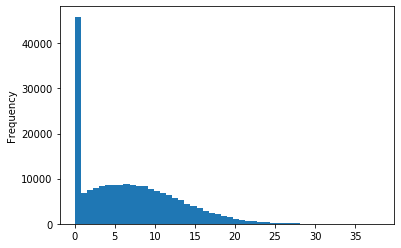

In [ ]:
df_calls['duration'].plot(kind = 'hist', bins =50);

в базе по звонкам **calls**:
- 202607 записей, без пропусков и дубликатов
- звонки с нулевой продолжительностью не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять
- заменить тип данных call_date    - перевести в даты
- продолжительность звонков от 1 до 11 мин, чаще 6 мин, максимально 38 мин. 
- пользователей (абонентов) всего 500

In [ ]:
print(df_internet.info())
print(df_internet.isna().sum())
print('______________________количество дубликатов', df_internet.duplicated().sum())
print(df_internet.describe().round(2))
print(df_internet.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
______________________количество дубликатов 0
       Unnamed: 0    mb_used    user_id
count   149396.00  149396.00  149396.00
mean     74697.50     370.19    1252.10
std      43127.05     278.30     144.05
min          0.00       0.00    1000.00
25%      37348.75     138.19    1130.00
50%      74697.50     348.02    1251.00
75%     112046.25     559.55    1380.00
max     149395.00    1724.83    1499.00
       Unnamed: 0        id  mb_used session_date  user_id
94635       94635   1320_53    56.75   2018-12-17     1320
96

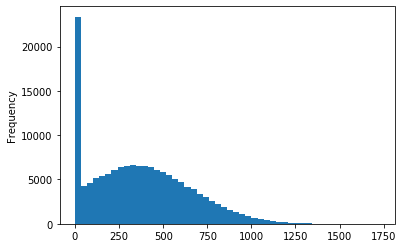

In [ ]:
df_internet['mb_used'].plot(kind = 'hist', bins =50);

в базе по интернет-трафику **internet**:
- 149396 записей, без пропусков и дубликатов
- соединение с нулевым трафиком - не ошибка данных, ошибка соединения, которое не будет учитываться при дальнейших расчетах. заменять нули не нужно.
- заменить тип данных session_date    - перевести в даты
- использован трафик от 138 Мб  до 560 Мб, чаще 348 Мб , максимально 1724 Мб. 
- есть столбец с индексами Unnamed - можно удалить скорее всего, т.к. у нас есть уникальный номер каждой сессии, состоящий из id пользователя и id  сессии.

In [ ]:
del df_internet['Unnamed: 0']  # удаляем лишний столбец
print(df_internet.head())

       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000


In [ ]:
print(df_messages.info())
print(df_messages.isna().sum())
print('______________________количество дубликатов', df_messages.duplicated().sum())
print(df_messages.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
id              0
message_date    0
user_id         0
dtype: int64
______________________количество дубликатов 0
             id message_date  user_id
65966  1282_398   2018-09-15     1282
90749  1375_549   2018-04-26     1375
55174  1244_340   2018-10-09     1244


в базе по сообщениям **df_messages**:
- 123036 записей, без пропусков и дубликатов
- заменить тип данных message_date        - перевести в даты

In [ ]:
print(df_tariffs.info())
print(df_tariffs.sample(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  


в базе по тарифам **df_tariffs**:
- всего 2 строки с основной информацией по тарифам

In [ ]:
print(df_users.info())
print(df_users.isna().sum())
print('______________________количество дубликатов', df_users.duplicated().sum())
print(df_users.describe().round(2))
print(df_users.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
______________________количество дубликатов 0
       user_id     age
count   500.00  500.00
mean   1249.50   46.59
std     144.48   16.67
min    1000.00   18.00
25%    1124.75   32.00
50%    1249.50   46.00
75%    1374.25   62.00
max    1499.00   75.00
     user_id  age churn_date             city first_name  last_name  \
127     1127   26        NaN           Казань   Альберта     Ильина   
379     1379   39  

In [ ]:
# проверим, что 1 user = 1 tarif (т.е. клиенты не меняли тарифы в течение года)
df_users.groupby('user_id')['tariff'].count().max()

1

In [ ]:
# переименуем столбец с названием тарифа в  'tariff_name', чтобы удобнее соединять с другими таблицами
print(df_users.columns)
df_users.set_axis(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name'], axis = 'columns', inplace = True)

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')


в базе по абонентам **df_users**:
- 500 записей, без дубликатов, 1 клиент = 1 тариф
- есть пропуски в колонке churn_date — дата прекращения пользования тарифом\
если значение пропущено, то тариф ещё действовал на момент выгрузки данных\
т.к. в 2018г клиентов всего 500, и 462 из них все еще активны, вероятно, это хороший результат, но можно сравнить с другими годами.
- рассчитать значение для замены пропусков в churn_date (дата выгрузки=макс дата регистрации клиента)
- заменить тип данных reg_date, churn_date - перевести в даты
- возраст клиента от 32 до 62 лет, чаще всего 46 лет, но есть 18 и 75летние тоже.

**план по дополнительной работе с данными**
1. провести предварительные вычисления:
    
    в базе по звонкам: 
    - округлить длительность каждого звонка до целых мин в большую сторону (df_calls['duration'])
    - сгруппировать (суммировать) полученные данные по id_user и по месяцам для дальнейшей обработки данных

    в базе по сообщениям
    - суммировать количество сообщений по id_user и по месяцам

    в базе по интернет-трафику:
    - сначала суммировать трафик по id_user и по месяцам
    - округлить трафик за месяц до целого количества гигабайт в большую сторону (1 гигабайт = 1024 мегабайта)

2. объединить базы в одну

## Подготовка данных
- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных, если они есть.
- Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

In [1]:
# изменим тип данных и создадим стобец с месяцем в каждой из 3 баз (звонки, трафик, сообщения):
df_calls['month'] = pd.to_datetime(df_calls['call_date']).dt.month
df_internet['month'] = pd.to_datetime(df_internet['session_date']).dt.month
df_messages['month'] = pd.to_datetime(df_messages['message_date']).dt.month
df_users['reg_month'] = pd.to_datetime(df_users['reg_date']).dt.month

NameError: ignored

In [ ]:
# заменим пропуски в базе абонентов в столбце 'churn_date' на мах дату 'reg_date', т.е. дату выгрузки данных
df_users.loc[df_users['churn_date'].isna(), 'churn_date'] = df_users['reg_date'].max()
df_users['churn_month'] = pd.to_datetime(df_users['churn_date']).dt.month

# новый столбец с количеством дней, сколько абонент был подписан на услуги в 2018 году (active_days_2018)
# дата подключения тарифа(reg_date) минус дата прекращения пользования тарифом (churn_date)
df_users['active_days_2018'] = pd.to_datetime(df_users['churn_date'])- pd.to_datetime(df_users['reg_date'])

In [ ]:
df_users['active_days_2018'] = df_users['active_days_2018'].dt.days # замена типа данных
df_users['active_days_2018'].describe() # проверка изменений

в 2018г половина клиентов подключена к услугам более 177 дней (больше полугода)

### Расчеты для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

количество сделанных звонков и израсходованных минут разговора по месяцам;

In [ ]:
# Округляем длительность разговора до целых минут в большую сторону
df_calls['duration_up'] = df_calls['duration'].apply(np.ceil)

In [ ]:
# группировка звонков по абоненту и месяцу
df_calls_user_month = df_calls.groupby(['user_id', 'month']).agg({'duration_up': ('sum', 'count')}).reset_index()
print(df_calls_user_month.info())
df_calls_user_month.head(5)

<div class="alert alert-info">
<b> я делала сначала через пивот, но что-то  пошло не так и я не смогла быстро разгруппировать составной индекс (user_id, month), чтобы получить столбец с месяцами отдельно.

Хотя сейчас вижу, что .reset_index()  хорошо работает и в этом случае, а тогда я пробовала более сложные способы. Пример в ячейке ниже</b>
<br>
</div>

In [ ]:
df_calls_user_month_pivot = df_calls.pivot_table(index=['user_id', 'month'], values='duration_up', aggfunc=('sum', 'count')).reset_index()

df_calls_user_month_pivot.info()
df_calls_user_month_pivot.sample(5)
#df_calls_user_month_pivot.columns

количество отправленных сообщений по месяцам;

In [ ]:
# группировка сообщений по абоненту и месяцу
df_messages_user_month = df_messages.groupby(['user_id', 'month']).agg({'id': ('count')}).reset_index()
df_messages_user_month.sample(5)

объем израсходованного интернет-трафика по месяцам;

In [ ]:
# группировка трафика по абоненту и месяцу
df_internet_user_month = df_internet.groupby(['user_id', 'month']).agg({'mb_used': ('sum', 'count')}).reset_index()
df_internet_user_month.columns

In [ ]:
# округление трафика за месяц в большую сторону (1 гигабайт = 1024 мегабайта)
df_internet_user_month['gb_used'] = (df_internet_user_month[('mb_used',   'sum')]/1024).apply(np.ceil)
df_internet_user_month.sample(5)

### сгруппируем отдельные базы в одну по user_id и месяцу

In [ ]:
# сначала звонки и трафик
data = df_calls_user_month.merge(df_internet_user_month, on = ['user_id', 'month'], how = 'outer')
# затем добавим сообщения
data = data.merge(df_messages_user_month, on = ['user_id', 'month'], how = 'outer')

print(data.columns) # проверяю список и наименования столбцов
data.sample(5)

In [ ]:
# удаляю задублированные столбцы user_id и month
data = data.drop(data.columns[[2, 3]], axis=1) 
data.columns

In [ ]:
# меняю названия столбцов на более читабельные
data.set_axis(['user_id', 'month',
               'calls_min', 
               'calls_count', 
               'mb_used', 
               'internet_count', 
               'gb_used', 
               'messages_count'], axis = 'columns', inplace = True)
data.head(5)

In [ ]:
data.isna().sum() # на этом этапе появились пропуски в данных

при объединении таблиц появились пропуски там, где клиент не пользовался услугой - не звонил, не отправлял сообщения, не использовал трафик. поэтому эти пропуски можно заменить на 0

In [ ]:
data = data.fillna(0)

In [ ]:
# добавляю дату подключения и название тарифа
data = data.merge(df_users, on = ['user_id'], how = 'inner')

In [ ]:
data.isna().sum()

In [ ]:
# добавляю характеристики тарифа по его названию
data = data.merge(df_tariffs, on = ['tariff_name'], how = 'outer')

print(data.columns) # проверяю список и наименования столбцов

<div class="alert alert-info">
<b> 
при первом объединении таблиц появились пропуски там, где клиент не пользовался услугой - не звонил, не отправлял сообщения, не использовал трафик - эти пропуски заменила на 0

потом присоединение тарифа сделала через inner
</b>
<br>
</div>

In [ ]:
data.info()

### помесячная выручка с каждого пользователя 

вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
остаток умножаем на значение из тарифного плана

In [ ]:
data['extra_calls'] = (data['calls_min'] - data['minutes_included']) * data['rub_per_minute']
data['extra_gb_trafic'] = (data['gb_used'] - data['mb_per_month_included']/1024) * data['rub_per_gb']
data['extra_messages'] = (data['messages_count'] - data['messages_included']) * data['rub_per_message']

иногда бесплатный лимит не превышается, поэтому убираю минусы, а также пропуски (клиент не использовал услугу по тарифу)

In [ ]:
#data.isna().sum()

for column in['extra_calls', 'extra_gb_trafic', 'extra_messages']:
    data.loc[data[column]<0, column] = 0
    data.loc[data[column].isna(), column] = 0

прибавим абонентскую плату 'rub_monthly_fee', соответствующую тарифному плану, и получим расходы за месяц

In [ ]:
data['user_monthly_fee'] = (data['rub_monthly_fee']
                            +data['extra_calls']
                            +data['extra_gb_trafic']
                            +data['extra_messages'])

медианные расходы за месяц усредненного абонента:
- наблюдается небольшая тенденция к росту среднего чека за месяц. 
- c увеличением числа клиентов колебания уменьшаются, и чаще всего клиент платит 1600-1800 рублей в месяц.

In [ ]:
data.groupby('month')['user_monthly_fee'].median().plot(grid = True);
plt.title("медианные расходы за месяц 1 клиента");
plt.xlabel("месяц");
plt.ylabel("расходы, руб");
plt.show()

In [ ]:
# количество абонентов каждого тарифа по месяцам
for tariff in ['smart', 'ultra']:
    data.query('tariff_name == @tariff').groupby('month')['user_monthly_fee'].count().plot(grid = True)
    plt.legend(['smart', 'ultra'])
    plt.xlabel('month')
    plt.ylabel('number of users')
    plt.title('Users per month')

In [ ]:
# стат характеристики каждого тарифа по расходам клиента в месяц:
data.groupby('tariff_name')['user_monthly_fee'].hist(bins=50, grid = True)
data.groupby('tariff_name')['user_monthly_fee'].describe().round(2)

рост среднего чека обусловлен интенсивным приростом количества абонентов, использующих более дешевый тариф smart:
- контрактов с тарифом Смарт больше, чем Ультра почти в 2 раза (2229/985)
- средний чек Смарт ниже, чем Ультра (1290/2070)
- Вспомнив размер базовой ежемесячной платы по каждому тарифу (Смарт =550 руб, Ультра=1950 руб), можно сделать вывод, что клиенты на дешевом тарифе Смарт чаще всего превышают базовую плату 550руб почти в 2 раза (медиана =1023 руб), в то время как клиенты тарифа Ультра остаются в рамках контракта (среднее = 2070, и только малая часть клиентов превышает эту сумму)
- это же подтверждает и показатель std (стандартное отклонение): на тарифе Смарт разброс больше, чем на Ультра (818/376)
- и на графике распределение 

## Анализ данных
Описать поведение клиентов оператора, исходя из выборки. 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы. Описать распределения.

### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

SMART


,count,mean,std,min,25%,50%,75%,max
calls_min,2229.00,417.93,190.31,0.00,282.00,422.00,545.00,1435.00
gb_used,2229.00,16.33,5.75,0.00,13.00,17.00,20.00,38.00
messages_count,2229.00,33.38,28.23,0.00,10.00,28.00,51.00,143.00
extra_calls,2229.00,124.82,254.04,0.00,0.00,0.00,135.00,2805.00
extra_gb_trafic,2229.00,597.76,736.56,0.00,0.00,400.00,1000.00,4600.00
extra_messages,2229.00,17.40,40.33,0.00,0.00,0.00,3.00,279.00
user_monthly_fee,2229.00,1289.97,818.40,550.00,550.00,1023.00,1750.00,6770.00


ULTRA


,count,mean,std,min,25%,50%,75%,max
calls_min,985.00,526.62,317.61,0.00,284.00,518.00,752.00,1673.00
gb_used,985.00,19.49,9.85,0.00,12.00,19.00,27.00,49.00
messages_count,985.00,49.36,47.80,0.00,6.00,38.00,79.00,224.00
extra_calls,985.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
extra_gb_trafic,985.00,120.15,376.19,0.00,0.00,0.00,0.00,2850.00
extra_messages,985.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
user_monthly_fee,985.00,2070.15,376.19,1950.00,1950.00,1950.00,1950.00,4800.00


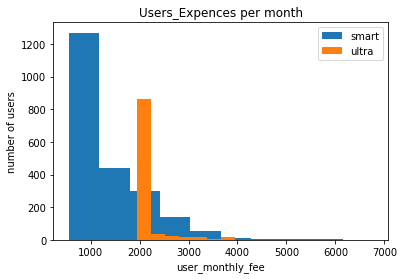

In [ ]:
for tariff in ('smart', 'ultra'):
    print(tariff.upper())
    df_temp = data.query('tariff_name == @tariff')
    display(df_temp[['calls_min', 'gb_used', 'messages_count', 'extra_calls', 'extra_gb_trafic', 'extra_messages', 'user_monthly_fee']].describe().T.style.format('{:.2f}'))
    plt.hist(df_temp['user_monthly_fee'], label = tariff)
plt.legend()
plt.xlabel('user_monthly_fee')
plt.ylabel('number of users')
plt.title('Users_Expences per month');

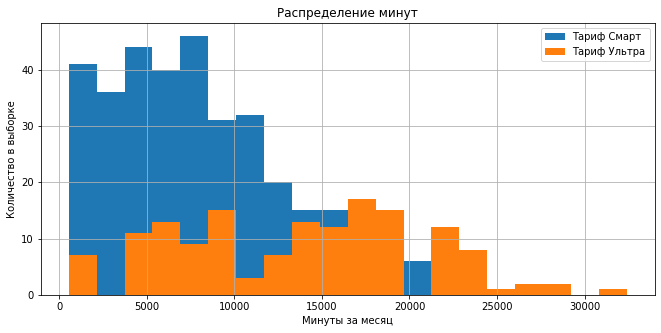

In [ ]:

ax = (data
         .pivot_table(index='user_id', columns='tariff_name',aggfunc={'user_monthly_fee':sum})
         .plot.hist(y='user_monthly_fee', figsize=(11, 5), grid=True, bins=20)
) 

plt.title("Распределение минут");
plt.legend(["Тариф Смарт", "Тариф Ультра"]);
plt.xlabel("Минуты за месяц");
plt.ylabel("Количество в выборке");
plt.show()

на тарифе Смарт экстра траты идут большей частью за счет перерасхода интернет-трафика - половине клиентов не хватает предоплаченного количества ГБ в месяц и эти клиенты доплачивают от 400 рублей в месяц. Также 25% клиентов Смарт доплачивают за доп. звонки и немного за сообщения.

на тарифе Ультра клиенты не доплачивают за звонки и сообщения, и свыше 75% клиентов не доплачивают за перерасход трафика, но некоторым все же не хватает ГБ даже на этом тарифе.

В целом на тарифе Смарт клиент тратит меньше минут (422/518), Гб (17/19), сообщений (28/38), чем средний клиент на тарифе Ультра, и несмотря на то, что клиенты Смарт активно используют услуги сверх тарифного пакета по повышенным ценам, средний чек Смарт (1290) < Ультра (2070).

### Расчеты - среднее количество, дисперсию и стандартное отклонение.

In [ ]:
for parameter in ['calls_min', 'gb_used', 'messages_count']:
    print(parameter.upper())
    print(data.groupby('tariff_name')[parameter].describe().round(2));

CALLS_MIN
              count    mean     std  min    25%    50%    75%     max
tariff_name                                                          
smart        2229.0  417.93  190.31  0.0  282.0  422.0  545.0  1435.0
ultra         985.0  526.62  317.61  0.0  284.0  518.0  752.0  1673.0
GB_USED
              count   mean   std  min   25%   50%   75%   max
tariff_name                                                  
smart        2229.0  16.33  5.75  0.0  13.0  17.0  20.0  38.0
ultra         985.0  19.49  9.85  0.0  12.0  19.0  27.0  49.0
MESSAGES_COUNT
              count   mean    std  min   25%   50%   75%    max
tariff_name                                                    
smart        2229.0  33.38  28.23  0.0  10.0  28.0  51.0  143.0
ultra         985.0  49.36  47.80  0.0   6.0  38.0  79.0  224.0


In [ ]:
# std (СКО) это то же самое, что и дисперсия (корень из дисперсии), 
for parameter in ['calls_min', 'gb_used', 'messages_count']:
    print(data.groupby('tariff_name').agg({parameter:('std', 'mean', 'var')}));

              calls_min                           
                    std        mean            var
tariff_name                                       
smart        190.313730  417.934948   36219.315784
ultra        317.606098  526.623350  100873.633397
              gb_used                      
                  std       mean        var
tariff_name                                
smart        5.747061  16.328847  33.028705
ultra        9.853511  19.494416  97.091686
            messages_count                        
                       std       mean          var
tariff_name                                       
smart            28.227876  33.384029   796.812958
ultra            47.804457  49.363452  2285.266143


### Построение гистограммы. Описание распределения.

calls_min


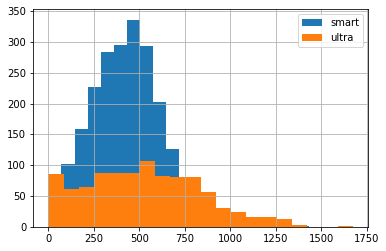

gb_used


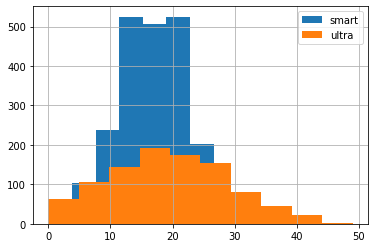

messages_count


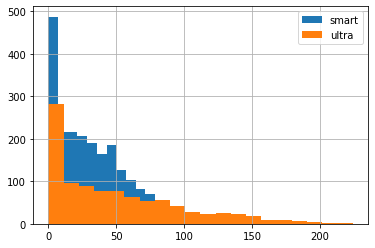

In [ ]:
print('calls_min')
data.groupby('tariff_name')['calls_min'].hist(bins=20, grid = True)
plt.legend(['smart', 'ultra'])
plt.show();

print('gb_used')
data.groupby('tariff_name')['gb_used'].hist(bins=10, grid = True)
plt.legend(['smart', 'ultra'])
plt.show();

print('messages_count')
data.groupby('tariff_name')['messages_count'].hist(bins=20, grid = True)
plt.legend(['smart', 'ultra'])
plt.show();

<div class="alert alert-info">
<b> уменьшила количество корзин и графики стали более наглядными

действительно, не нужно стараться уместить и показать в таблице или графике все особенности распределения, а только то, о чем делаю вывод.

я брала много корзин, чтобы показать несколько пиков, но на этом этапе так делать - только отвлекать читателя отчета
</b>
<br>
</div>

по графикам видно, что среднее значение каждого из 3 показателей на тарифе Смарт значительно выше, чем Ультра

Частотное распределение, представленное для тарифа Ультра, более переменчиво (с широким разбросом), чем частотное распределение, представленное Смарт. дисперсия и стандартное отклонение для Ультры больше, чем для Смарт.

## Проверка гипотез

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
H0 - средняя выручка пользователей тарифов равна (одинакова)\
Н1 - средняя выручка отличается

In [ ]:
# создадим отдельные выборки для каждого тарифа
smart = data.query ('tariff_name == "smart"')['user_monthly_fee']
ultra = data.query ('tariff_name == "ultra"')['user_monthly_fee']

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(smart, ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


вывод - средняя выручка пользователей тарифов отличается

### средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.
H0 - средняя выручка пользователей из Москвы равна выручке из других регионов (одинакова)\
Н1 - средняя выручка отличается

In [ ]:
data['city'].unique() # список населенных пунктов
data['region'] = 'Moscow' # создаю новый столбец и заполняю одинаково
data.loc[data['city'] != 'Москва', ['region']] = 'Others'  # если этот клиент не из Москвы, но заменяю значение
data['region'].unique() # проверка

array(['Others', 'Moscow'], dtype=object)

In [ ]:
# создадим отдельные выборки для каждого тарифа
Moscow = data.query ('region == "Moscow"')['user_monthly_fee']
Regions = data.query ('region == "Others"')['user_monthly_fee']

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(Moscow, Regions)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


вывод - средняя выручка пользователей из Москвы равна выручке из других регионов (одинакова)

## Общий вывод

на основе проведенного анализа можно предположить, что клиенты компании-заказчика:
- в основном выбирают более дешевый тариф Смарт, но готовы платить за дополнительные услуги.
- экстра плата (сверх стандартного пакета услуг) поступает в основном от клиентов Смарт за перерасход интернет-трафика
- в тариф Ультра включено довольно много услуг и по более высоким ценам, чем Смарт. Возможно, высокая цена подписки подкреплена дополнительным клиентским сервисом или более высокой скоростью передачи данных, т.к. количество клиентов Ультра также увеличивается, хоть и медленнее, чем клиентов Смарт
- проверка гипотез показала, что выручка по тарифам отличается, но место жительства такого влияния на размер средней выручки не оказывает.

с учетом полученной информации можно провести дополнительные исследования и разработать новую тарифную сетку и привлечь новых категории клиентов.

<div class="alert alert-info">
<b> 
Компании выгоднее продвигать тариф Ультра потому, что:
    
- клиенты Смарт часто выходят за рамки предоплаченного трафика и звонков, сообщений - т.е. есть спрос 
- несмотря на то, что клиенты Смарт активно используют услуги сверх тарифного пакета по повышенным ценам, средний чек Смарт (1290) все еще меньше, чем Ультра (2070).
- количество клиентов каждого тарифа продолжает расти, 
- можно предположить, что тариф Смарт останется востребованным и без дополнительной поддержки. Можно было бы рассчитывать на грандиозный рост выручки за счет прироста количества клиентов, ориентируюсь на регионы с низким доходом (не мегаполисы), но анализ показал, что средняя выручка пользователей из Москвы равна выручке из других регионов
- поэтому лучше сфокусироваться на поддержке тарифа Ультра.
</b>
<br>
</div>

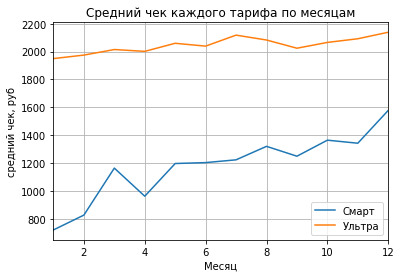

In [ ]:
# количество абонентов каждого тарифа по месяцам
for tariff in ['smart', 'ultra']:
    data.query('tariff_name == @tariff').groupby('month')['user_monthly_fee'].mean().plot(grid = True)
    plt.legend(['Смарт', 'Ультра'])
    plt.xlabel('Месяц')
    plt.ylabel('средний чек, руб')
    plt.title('Средний чек каждого тарифа по месяцам')